In [ ]:
# Available Topics correspond to the ploting function:
# ("lemma_length_analysis",plot_lemma_length)
# ("word_length_analysis",plot_word_length)
# ("lexicon_analysis", plot_lexicon_analysis)
# ("sentiment_dist_analysis",plot_sentiment_dist)
# ("word_freq_with_stopwords",plot_word_freq_with_stopwords)
# ("word_freq_without_stopwords",plot_word_freq_without_stopwords)
# ("POSDistribution",plot_POS_distribution)
# ("morphological_analysis",plot_morphological)
from lexicraft import AnalysisVisualization

In [ ]:
from lexicraft import AnalysisVisualization
AnalysisVisualization.visualize_analysis_topic("lemma_length_analysis", AnalysisVisualization.plot_lemma_length, False, 'localhost:9092', 0)

In [ ]:
AnalysisVisualization.visualize_analysis_topic("word_length_analysis", AnalysisVisualization.plot_word_length, False, 'localhost:9092', 0)

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=values, palette='viridis')


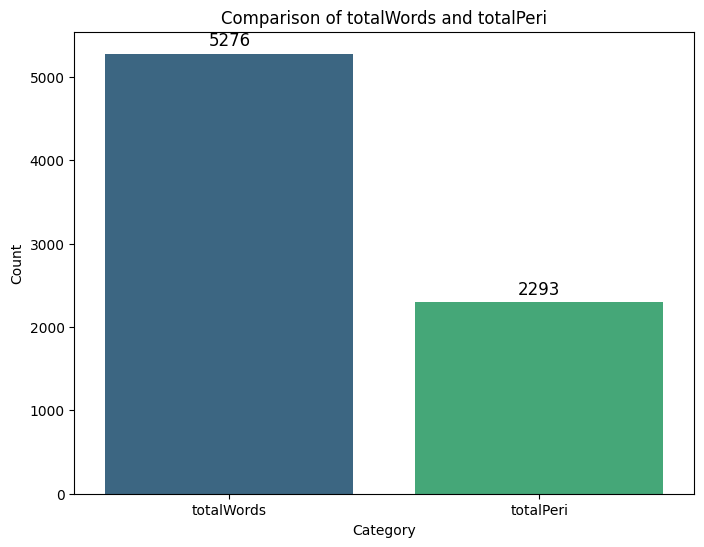

Last Analysis Result Received Time:  2024-12-19 20:24:59


In [4]:
AnalysisVisualization.visualize_analysis_topic("lexicon_analysis", AnalysisVisualization.plot_lexicon_analysis, False, 'localhost:9092', 0)

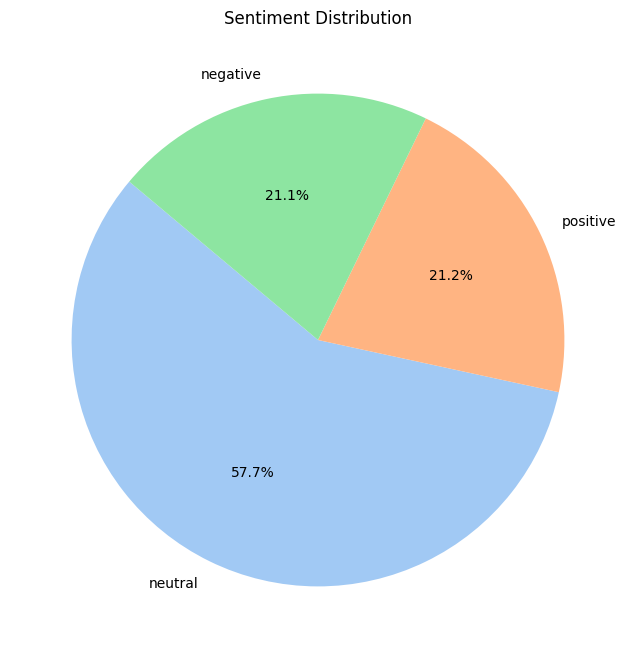

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos, y=counts, palette="coolwarm")


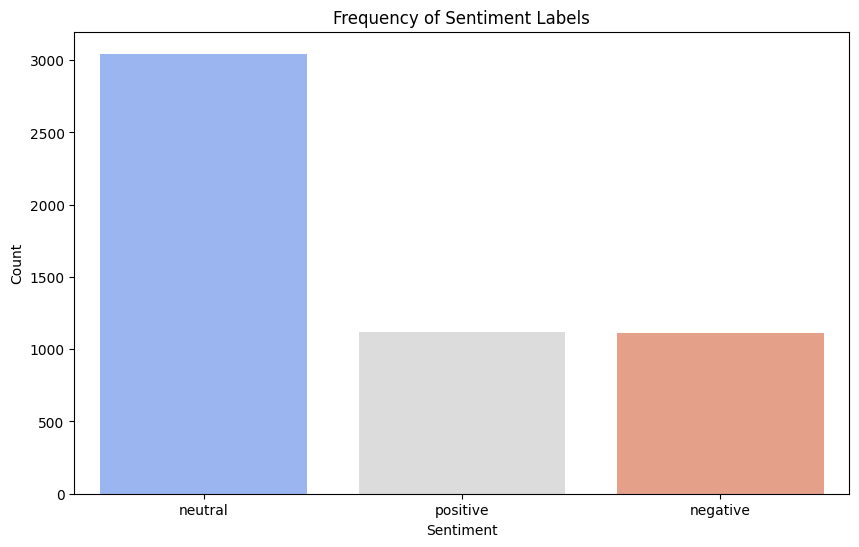

Last Analysis Result Received Time:  2024-12-19 20:25:24


In [5]:
AnalysisVisualization.visualize_analysis_topic("sentiment_dist_analysis", AnalysisVisualization.plot_sentiment_dist, False, 'localhost:9092', 0)

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette="viridis")


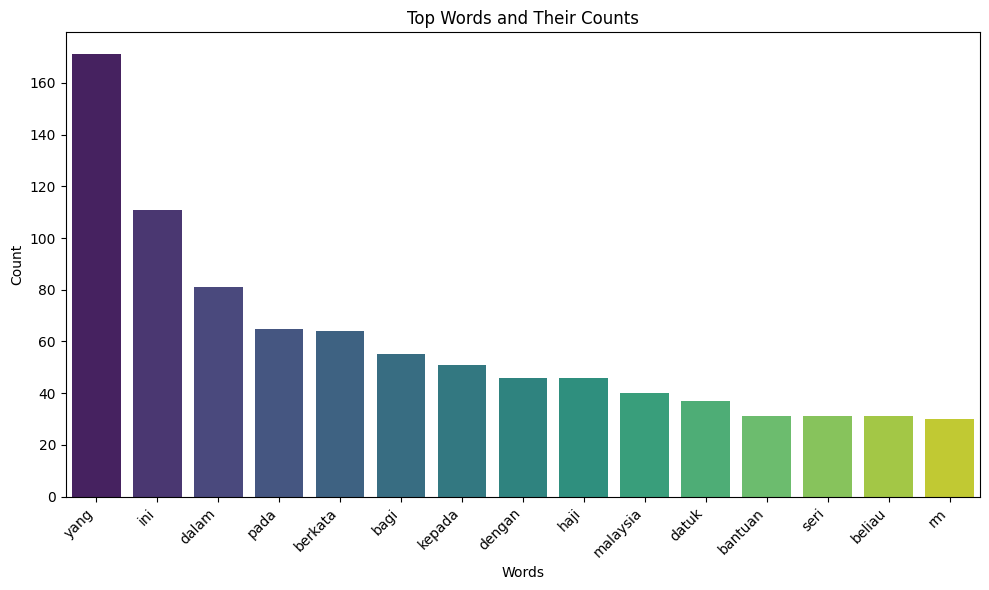

Last Analysis Result Received Time:  2024-12-19 20:25:24


In [6]:
AnalysisVisualization.visualize_analysis_topic("word_freq_with_stopwords", AnalysisVisualization.plot_word_freq_with_stopwords, False, 'localhost:9092', 0)

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette="viridis")


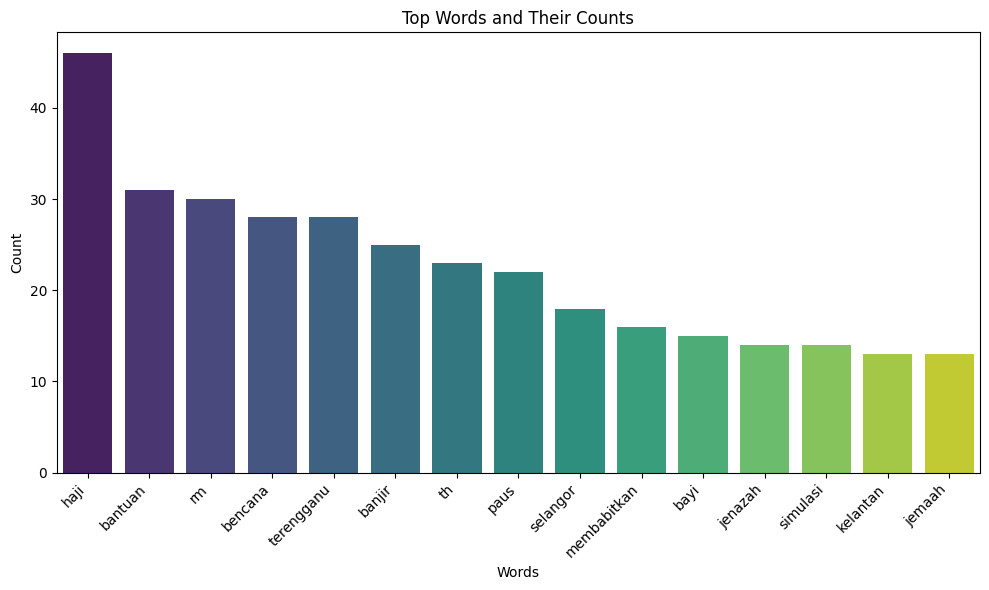

Last Analysis Result Received Time:  2024-12-19 20:25:25


In [7]:

AnalysisVisualization.visualize_analysis_topic("word_freq_without_stopwords", AnalysisVisualization.plot_word_freq_without_stopwords, False, 'localhost:9092', 0)

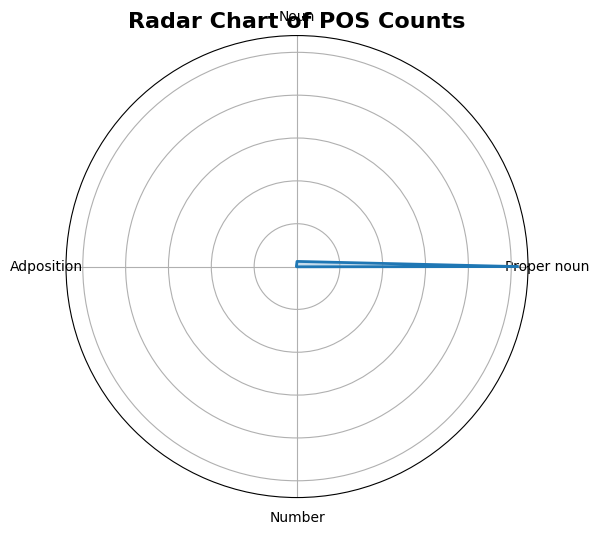

Last Analysis Result Received Time:  2024-12-19 20:25:24


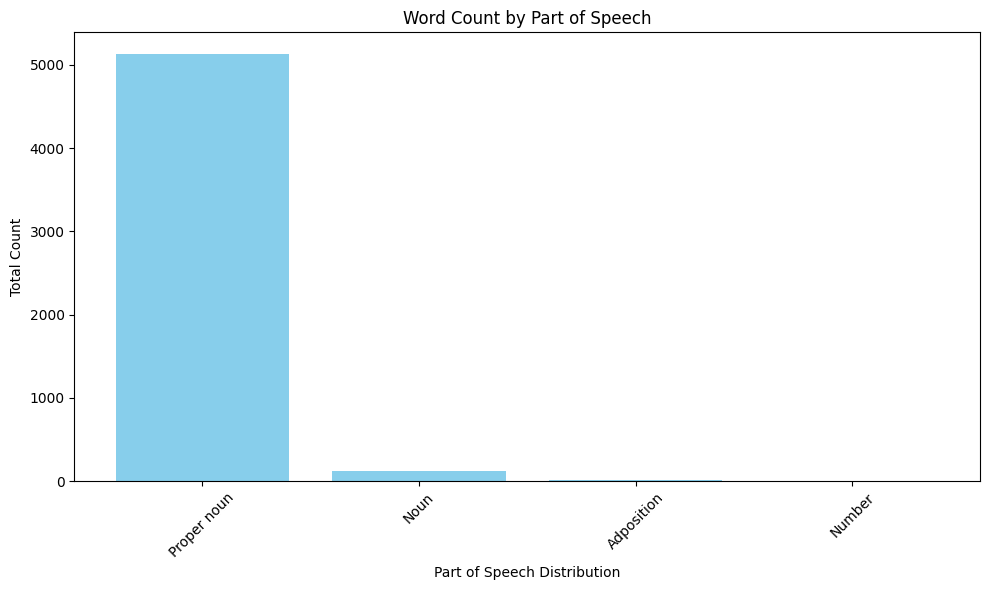

In [1]:
from visualize_analysis import AnalysisVisualization
AnalysisVisualization.visualize_analysis_topic("POSDistribution", AnalysisVisualization.plot_POS_distribution, False, 'localhost:9092', 0)

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prefix_counts.index, y=prefix_counts.values, palette="viridis")


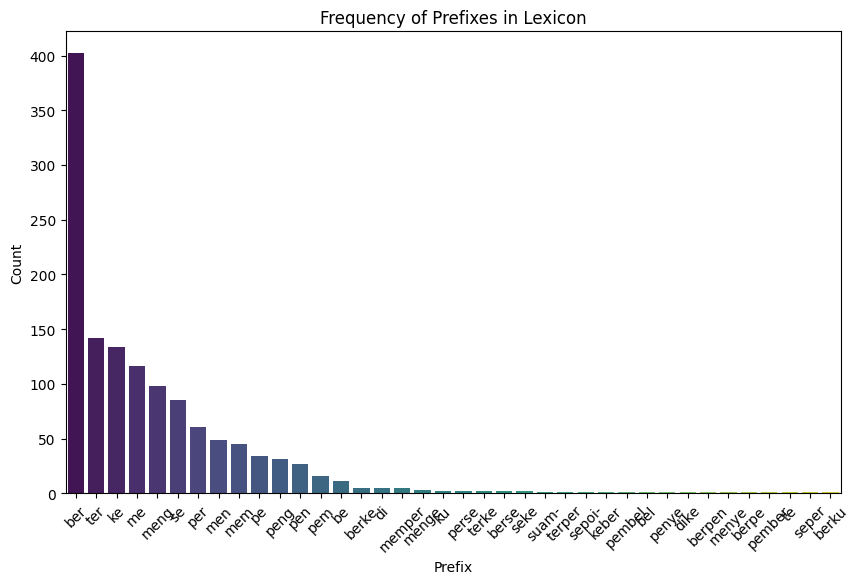

/home/student/DE_malay_news/lexicraft/visualize_analysis.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suffix_counts.index, y=suffix_counts.values, palette="magma")


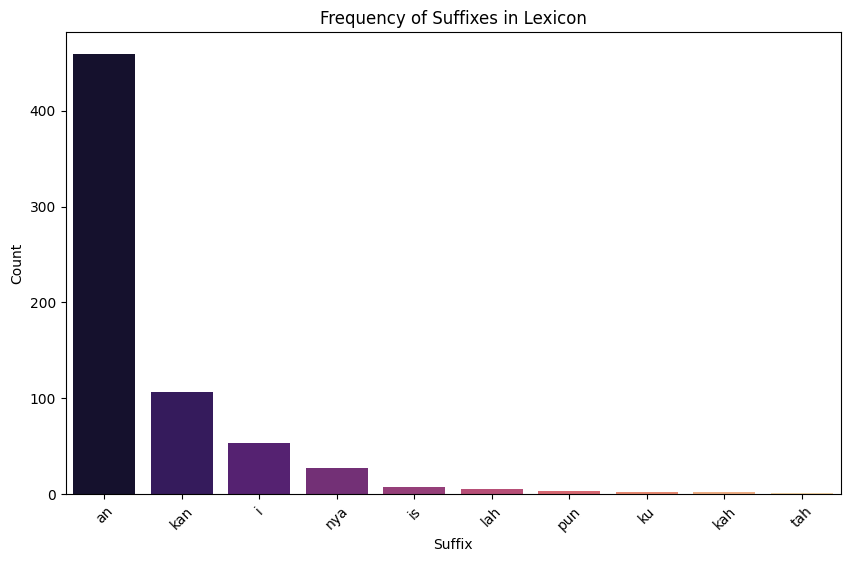

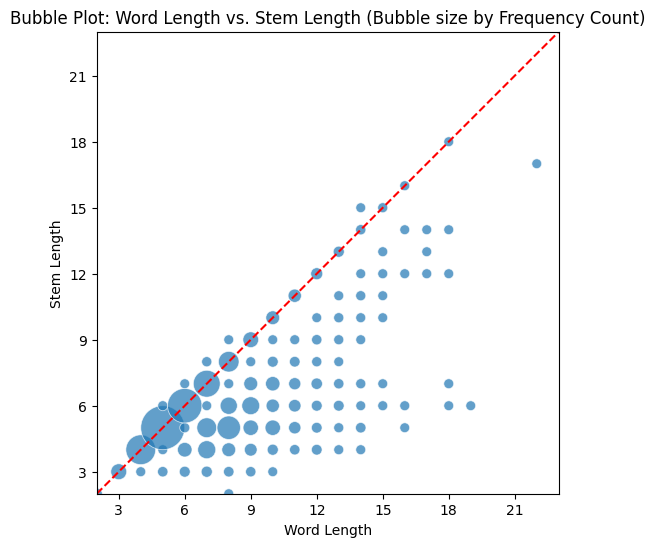

Last Analysis Result Received Time:  2024-12-19 20:25:23


In [9]:
AnalysisVisualization.visualize_analysis_topic("morphological_analysis", AnalysisVisualization.plot_morphological, False, 'localhost:9092', 0)

In [10]:
message = AnalysisVisualization.get_kafka_topic_latest_message("lemma_length_analysis",'localhost:9092', 0)
print(message.value)

{'word_lengths': [8, 6, 7, 6, 6, 5, 3, 4, 6, 5, 4, 6, 3, 5, 5, 5, 5, 6, 5, 5, 5, 4, 11, 4, 5, 4, 8, 5, 4, 5, 5, 3, 6, 5, 5, 14, 5, 6, 6, 4, 11, 5, 9, 4, 5, 3, 8, 8, 5, 2, 5, 5, 3, 9, 3, 6, 10, 4, 7, 5, 5, 5, 4, 8, 7, 9, 4, 6, 5, 5, 9, 4, 6, 13, 5, 6, 4, 4, 6, 5, 10, 5, 7, 7, 3, 4, 4, 7, 5, 6, 5, 5, 6, 12, 4, 4, 3, 3, 5, 6, 6, 6, 10, 13, 3, 5, 10, 3, 3, 5, 6, 6, 3, 3, 12, 5, 5, 6, 6, 4, 4, 10, 5, 5, 5, 7, 8, 5, 4, 11, 4, 5, 3, 4, 4, 7, 7, 5, 6, 6, 6, 7, 3, 9, 4, 5, 7, 5, 5, 7, 6, 5, 13, 6, 12, 3, 6, 5, 6, 4, 6, 5, 6, 6, 6, 5, 8, 5, 5, 6, 8, 5, 3, 5, 9, 5, 5, 5, 5, 13, 10, 5, 6, 4, 6, 3, 3, 3, 4, 8, 5, 4, 5, 10, 6, 4, 8, 5, 4, 9, 6, 6, 6, 5, 14, 6, 4, 4, 4, 6, 11, 5, 6, 4, 10, 7, 5, 7, 4, 5, 6, 5, 5, 6, 6, 8, 6, 6, 4, 6, 5, 9, 5, 5, 5, 15, 6, 5, 6, 6, 5, 6, 5, 8, 9, 7, 3, 5, 5, 5, 5, 7, 5, 5, 5, 6, 6, 4, 5, 5, 8, 7, 5, 3, 5, 5, 5, 6, 6, 4, 5, 6, 4, 7, 5, 7, 6, 5, 4, 6, 6, 5, 8, 7, 6, 6, 5, 7, 7, 9, 5, 5, 8, 7, 11, 4, 14, 6, 5, 9, 7, 6, 5, 6, 4, 6, 6, 7, 7, 6, 7, 8, 5, 5, 5, 11, 6, 9, 6, 

In [11]:
message = AnalysisVisualization.get_kafka_topic_latest_message("word_length_analysis",'localhost:9092', 0)
print(message.value)

{'word_lengths': [8, 6, 7, 6, 6, 5, 3, 4, 8, 5, 4, 6, 4, 7, 5, 5, 5, 6, 5, 9, 5, 9, 11, 4, 9, 4, 8, 5, 9, 5, 9, 3, 6, 5, 5, 18, 5, 6, 6, 4, 11, 9, 9, 4, 5, 5, 8, 8, 5, 2, 5, 5, 3, 9, 3, 6, 10, 4, 7, 5, 5, 5, 4, 8, 7, 9, 4, 6, 5, 5, 9, 4, 9, 13, 7, 6, 7, 4, 6, 8, 10, 5, 7, 7, 3, 4, 4, 10, 5, 6, 7, 5, 6, 12, 6, 4, 3, 3, 5, 6, 6, 6, 10, 13, 3, 5, 10, 3, 3, 5, 5, 12, 3, 3, 17, 5, 5, 6, 6, 4, 4, 10, 5, 5, 9, 7, 8, 7, 4, 11, 4, 5, 3, 4, 4, 9, 7, 5, 6, 6, 6, 7, 4, 10, 4, 5, 7, 5, 11, 7, 9, 5, 13, 6, 12, 9, 6, 5, 6, 4, 6, 5, 6, 6, 6, 5, 8, 7, 8, 6, 8, 5, 3, 5, 9, 9, 9, 5, 5, 13, 14, 5, 10, 8, 6, 5, 5, 3, 4, 8, 9, 6, 5, 10, 10, 8, 8, 12, 6, 9, 6, 6, 9, 8, 14, 9, 6, 7, 7, 9, 11, 8, 6, 8, 10, 11, 5, 7, 4, 7, 9, 5, 9, 10, 6, 8, 6, 9, 8, 9, 9, 12, 5, 8, 5, 14, 10, 5, 6, 8, 9, 6, 5, 10, 9, 7, 3, 5, 5, 5, 5, 7, 5, 5, 5, 6, 6, 4, 5, 5, 8, 7, 5, 3, 5, 9, 9, 6, 8, 8, 5, 6, 4, 7, 8, 7, 9, 5, 6, 9, 8, 5, 8, 9, 6, 8, 5, 7, 7, 9, 5, 5, 8, 7, 14, 4, 14, 6, 5, 9, 10, 8, 10, 6, 4, 6, 6, 11, 7, 10, 7, 8, 5, 9, 

In [12]:
message = AnalysisVisualization.get_kafka_topic_latest_message("lexicon_analysis",'localhost:9092', 0)
print(message.value)

[{'totalWords': 5276, 'totalPeri': 2293}]


In [13]:
message = AnalysisVisualization.get_kafka_topic_latest_message("sentiment_dist_analysis",'localhost:9092', 0)
print(message.value)

[{'label': 'neutral', 'total_count': 3045}, {'label': 'positive', 'total_count': 1118}, {'label': 'negative', 'total_count': 1113}]


In [14]:
message = AnalysisVisualization.get_kafka_topic_latest_message("word_freq_with_stopwords",'localhost:9092', 0)
print(message.value)

[{'word': 'yang', 'count': 171}, {'word': 'ini', 'count': 111}, {'word': 'dalam', 'count': 81}, {'word': 'pada', 'count': 65}, {'word': 'berkata', 'count': 64}, {'word': 'bagi', 'count': 55}, {'word': 'kepada', 'count': 51}, {'word': 'dengan', 'count': 46}, {'word': 'haji', 'count': 46}, {'word': 'malaysia', 'count': 40}, {'word': 'datuk', 'count': 37}, {'word': 'bantuan', 'count': 31}, {'word': 'seri', 'count': 31}, {'word': 'beliau', 'count': 31}, {'word': 'rm', 'count': 30}]


In [15]:
message = AnalysisVisualization.get_kafka_topic_latest_message("word_freq_without_stopwords",'localhost:9092', 0)
print(message.value)

[{'word': 'haji', 'count': 46}, {'word': 'bantuan', 'count': 31}, {'word': 'rm', 'count': 30}, {'word': 'bencana', 'count': 28}, {'word': 'terengganu', 'count': 28}, {'word': 'banjir', 'count': 25}, {'word': 'th', 'count': 23}, {'word': 'paus', 'count': 22}, {'word': 'selangor', 'count': 18}, {'word': 'membabitkan', 'count': 16}, {'word': 'bayi', 'count': 15}, {'word': 'jenazah', 'count': 14}, {'word': 'simulasi', 'count': 14}, {'word': 'kelantan', 'count': 13}, {'word': 'jemaah', 'count': 13}]


In [16]:
message = AnalysisVisualization.get_kafka_topic_latest_message("POSDistribution",'localhost:9092', 0)
print(message.value)

[{'pos': 'Proper noun', 'total_count': 5135}, {'pos': 'Noun', 'total_count': 120}, {'pos': 'Adposition', 'total_count': 15}, {'pos': 'Number', 'total_count': 6}]


In [17]:
message = AnalysisVisualization.get_kafka_topic_latest_message("morphological_analysis",'localhost:9092', 0)
print(message.value)

[{"word":"forestry","stem":"forestry","prefix":null,"suffix":null,"core_word":"forestry"},{"word":"jagaan","stem":"jaga","prefix":"","suffix":"an","core_word":"jaga"},{"word":"forever","stem":"forever","prefix":null,"suffix":null,"core_word":"forever"},{"word":"hujung","stem":"hujung","prefix":null,"suffix":null,"core_word":"hujung"},{"word":"formal","stem":"formal","prefix":null,"suffix":null,"core_word":"formal"},{"word":"forum","stem":"forum","prefix":null,"suffix":null,"core_word":"forum"},{"word":"jam","stem":"jam","prefix":null,"suffix":null,"core_word":"jam"},{"word":"foto","stem":"foto","prefix":null,"suffix":null,"core_word":"foto"},{"word":"jambatan","stem":"jambat","prefix":"","suffix":"an","core_word":"jambat"},{"word":"gagal","stem":"gagal","prefix":null,"suffix":null,"core_word":"gagal"},{"word":"hulu","stem":"hulu","prefix":null,"suffix":null,"core_word":"hulu"},{"word":"jambat","stem":"jambat","prefix":null,"suffix":null,"core_word":"jambat"},{"word":"hadi","stem":"had"